<a href="https://www.kaggle.com/code/rizkynindra/star-regression?scriptVersionId=145417925" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-star-regression/Data Star (1).xlsx


In [2]:
df = pd.read_excel('/kaggle/input/data-star-regression/Data Star (1).xlsx')
df

,month_year,revenue,#qty order,#unique order id,comodity_price,comodity_price_lag1,comodity_price_lag2,comodity_price_lag3,comodity_price_lag4,comodity_price_lag5,comodity_price_lag6,kurs_eur,kurs_usd
0,2016-01,254545455,1,1,26.567500,26.800000,26.890000,26.626364,27.831818,28.546190,29.388696,15139,13846
1,2016-03,900000000,1,1,26.636667,26.567500,26.800000,26.890000,26.626364,27.831818,28.546190,15029,13276
2,2016-05,15280909091,10,3,27.138947,26.636667,26.567500,26.800000,26.890000,26.626364,27.831818,15176,13615
3,2016-06,20903600000,10,3,28.156667,27.138947,26.636667,26.567500,26.800000,26.890000,26.626364,14650,13180
4,2016-07,12921200000,5,2,29.389524,28.156667,27.138947,26.636667,26.567500,26.800000,26.890000,14512,13094
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,2023-04,17798360000,11,2,71.500556,73.836522,83.241905,92.173500,88.208636,91.664545,87.132500,16160,14751
78,2023-05,22206374000,11,7,68.187500,71.500556,73.836522,83.241905,92.173500,88.208636,91.664545,16016,14969
79,2023-06,24880208342,14,6,53.540455,68.187500,71.500556,73.836522,83.241905,92.173500,88.208636,16171,15026
80,2023-07,14751175000,12,4,52.396667,53.540455,68.187500,71.500556,73.836522,83.241905,92.173500,16576,15083


Berdasarkan code diatas, terlihat bahwa kita memiliki data sebanyak 82 records dan target yang dituju adalah "revenue". Selanjutnya kita cek untuk datanya apakah ada null value atau tidak.

In [3]:
df.isnull().sum()

month_year              0
revenue                 0
#qty order              0
#unique order id        0
 comodity_price         0
 comodity_price_lag1    0
 comodity_price_lag2    0
 comodity_price_lag3    0
 comodity_price_lag4    0
 comodity_price_lag5    0
 comodity_price_lag6    0
kurs_eur                0
kurs_usd                0
dtype: int64

Terlihat bahwa data sudah aman, tidak ada yang kosong. Selanjutnya kita cek tipe data dari masing-masing fitur.

In [4]:
df.dtypes

month_year               object
revenue                   int64
#qty order                int64
#unique order id          int64
 comodity_price         float64
 comodity_price_lag1    float64
 comodity_price_lag2    float64
 comodity_price_lag3    float64
 comodity_price_lag4    float64
 comodity_price_lag5    float64
 comodity_price_lag6    float64
kurs_eur                  int64
kurs_usd                  int64
dtype: object

kita punya tipe data "object" , berhubung untuk studi kasus regresi fitur tersebut tidak kita butuhkan, jadi kita hapus saja.

In [5]:
df_new = df.drop("month_year", axis='columns')
df_new

,revenue,#qty order,#unique order id,comodity_price,comodity_price_lag1,comodity_price_lag2,comodity_price_lag3,comodity_price_lag4,comodity_price_lag5,comodity_price_lag6,kurs_eur,kurs_usd
0,254545455,1,1,26.567500,26.800000,26.890000,26.626364,27.831818,28.546190,29.388696,15139,13846
1,900000000,1,1,26.636667,26.567500,26.800000,26.890000,26.626364,27.831818,28.546190,15029,13276
2,15280909091,10,3,27.138947,26.636667,26.567500,26.800000,26.890000,26.626364,27.831818,15176,13615
3,20903600000,10,3,28.156667,27.138947,26.636667,26.567500,26.800000,26.890000,26.626364,14650,13180
4,12921200000,5,2,29.389524,28.156667,27.138947,26.636667,26.567500,26.800000,26.890000,14512,13094
...,...,...,...,...,...,...,...,...,...,...,...,...
77,17798360000,11,2,71.500556,73.836522,83.241905,92.173500,88.208636,91.664545,87.132500,16160,14751
78,22206374000,11,7,68.187500,71.500556,73.836522,83.241905,92.173500,88.208636,91.664545,16016,14969
79,24880208342,14,6,53.540455,68.187500,71.500556,73.836522,83.241905,92.173500,88.208636,16171,15026
80,14751175000,12,4,52.396667,53.540455,68.187500,71.500556,73.836522,83.241905,92.173500,16576,15083


Selanjutnya kita tampilkan correlation matrix untuk melihat korelasi setiap fiturnya

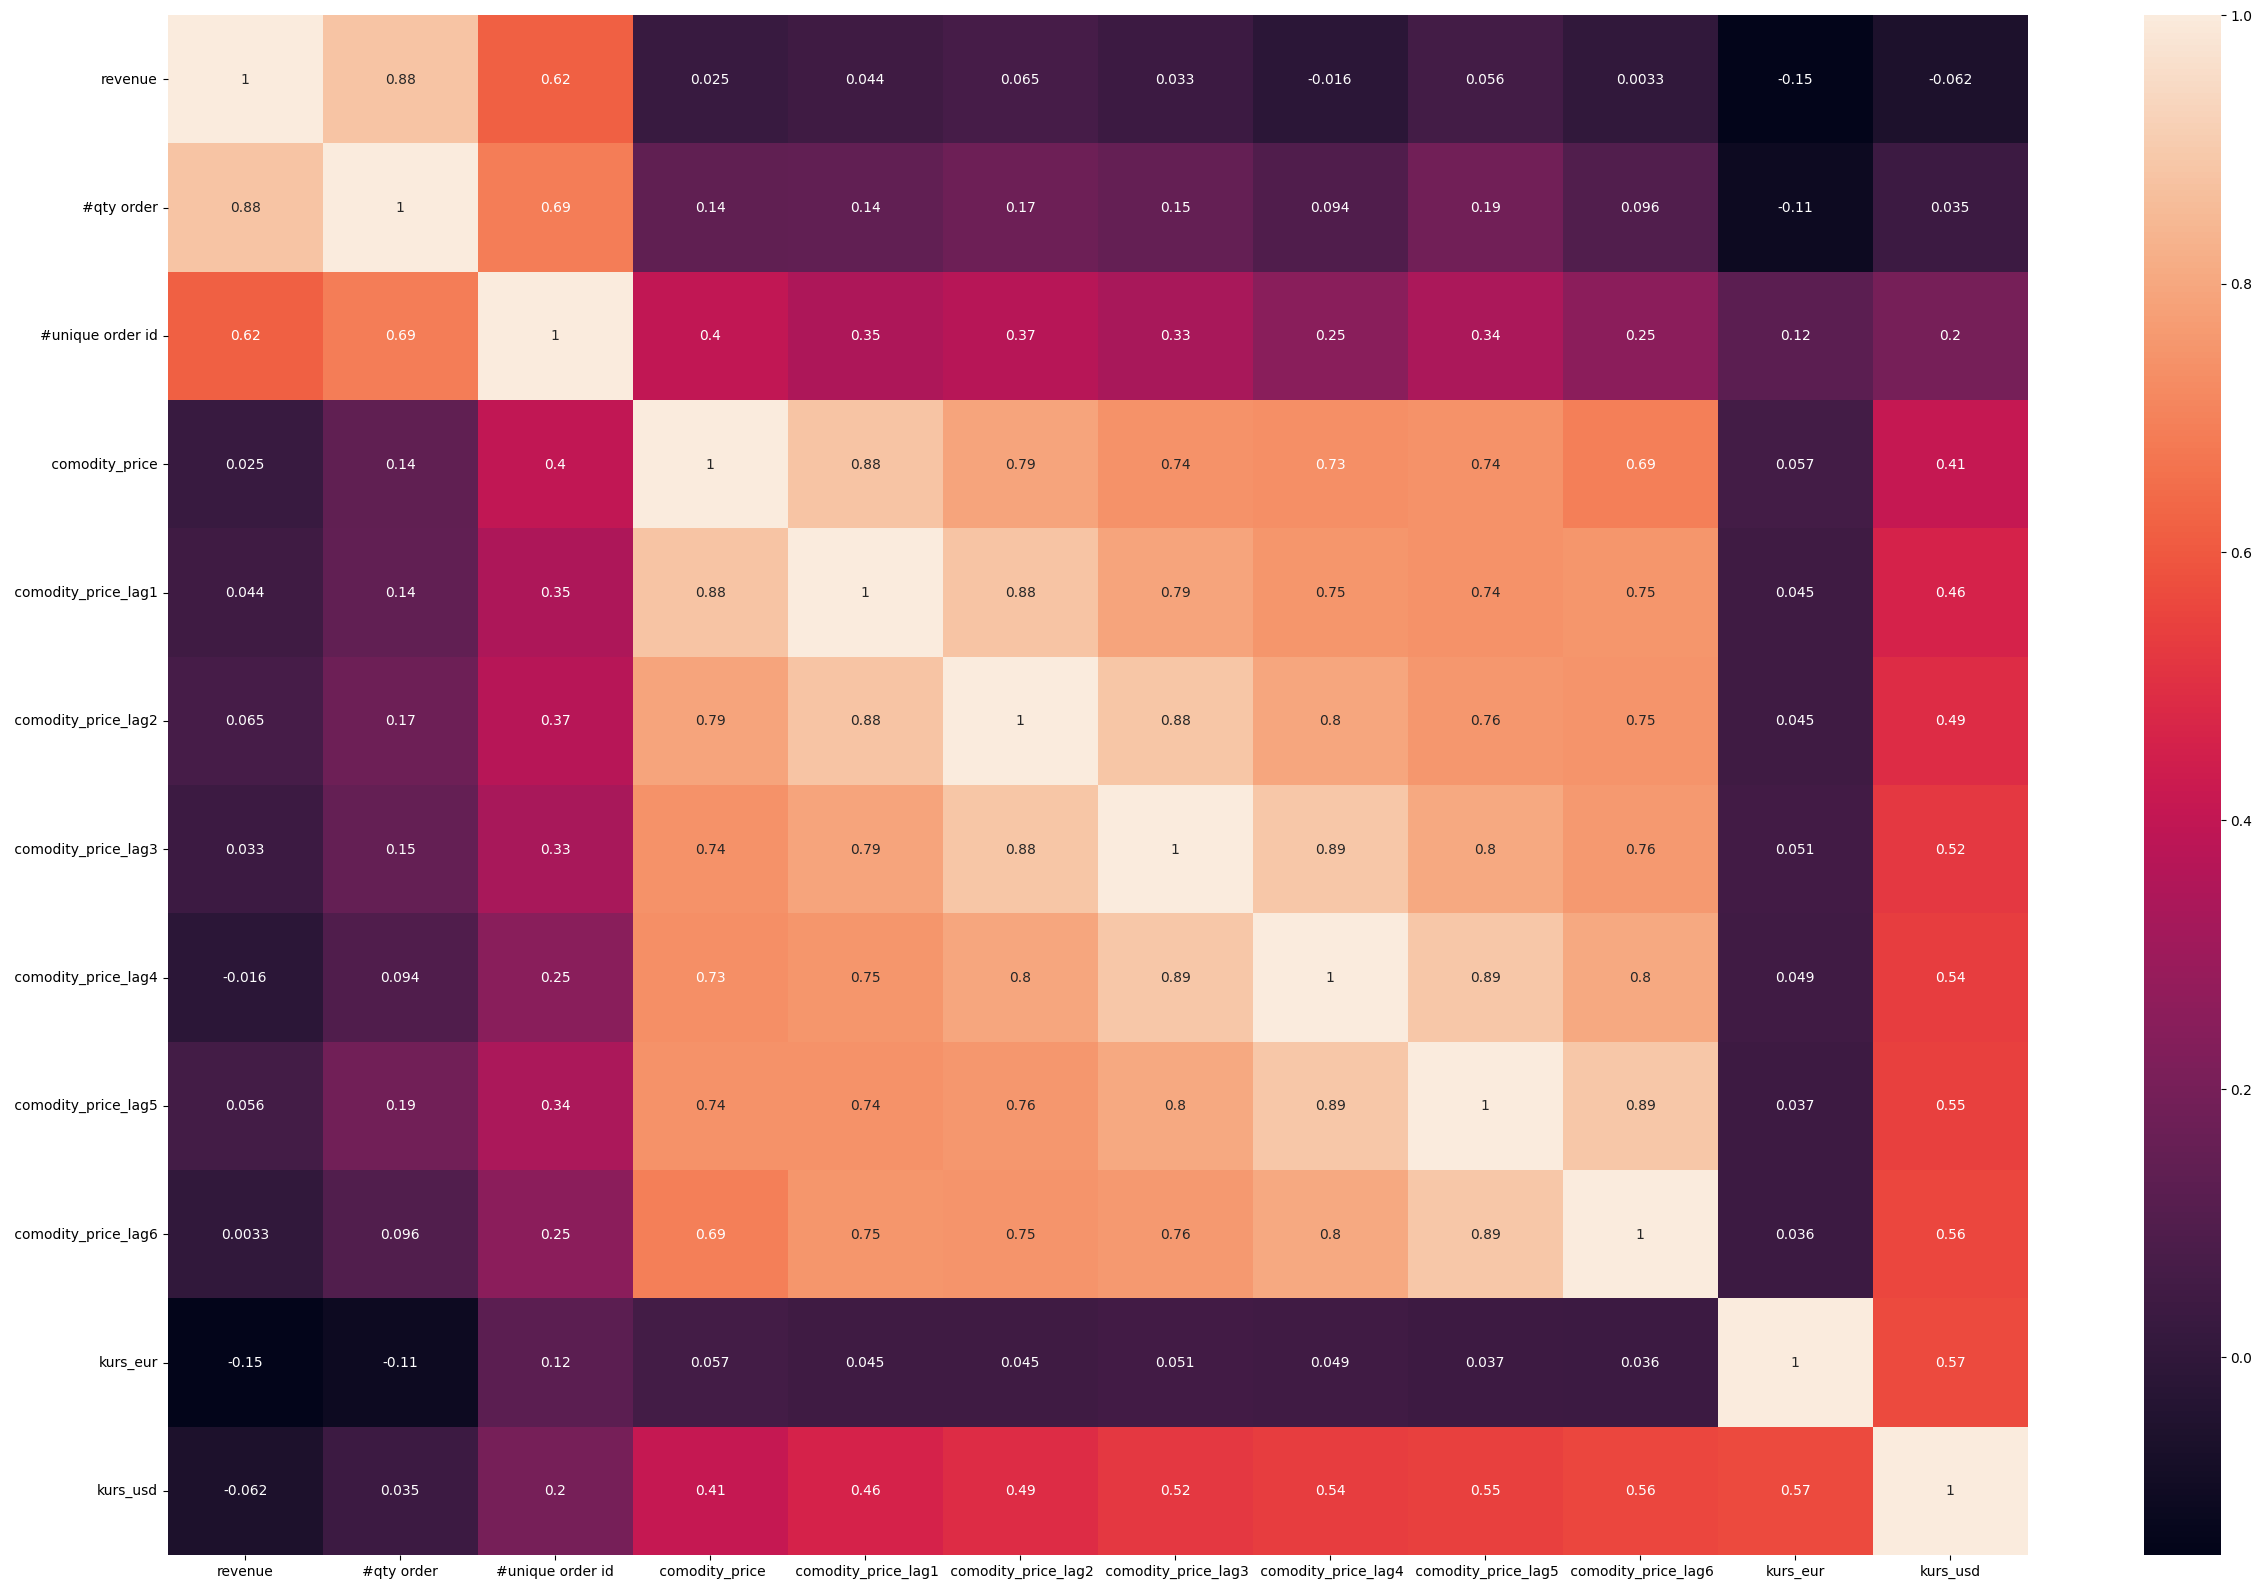

In [6]:
corr_matrix = df_new.corr()
plt.figure(figsize=(30,20))
sns.heatmap(corr_matrix, annot=True)
plt.show()

berdasarkan hasil correlation matrix diatas dapat terlihat bahwa korelasi tertinggi terhadap "revenue" adalah "#qty order" . Namun kita tidak bisa hanya menggunakan fitur ini saja, jadi disini bisa kita filter untuk mengambil fitur dengan nilai korelasi lebih dari 0.1

In [7]:
#feature selection versi 1
corr = abs(df_new.corr()['revenue'])
corr[corr>0.1]


#feature selection versi 2
# corr = abs(df_new.corr()['revenue'])
# corr[corr>0.5]

revenue             1.000000
#qty order          0.880137
#unique order id    0.618015
kurs_eur            0.147456
Name: revenue, dtype: float64

Akhirnya kita mendapat 3 fitur yang dapat kita gunakan yaitu "#qty order", "#unique order id", dan "kurs_eur". Selanjutnya kita pisahkan datanya menjadi training data dan testing data

In [8]:
#pembuatan x versi feature selection 1
x = pd.DataFrame([df_new['#qty order'],df_new['#unique order id'],df_new['kurs_eur']])

#pembuatan x versi feature selection 2
# x = pd.DataFrame([df_new['#qty order'],df_new['#unique order id']])

xtrain = x.transpose()
y = df_new['revenue']

print(xtrain.shape)
print(y.shape)
print("\n")

xtrain

(82, 3)
(82,)




,#qty order,#unique order id,kurs_eur
0,1,1,15139
1,1,1,15029
2,10,3,15176
3,10,3,14650
4,5,2,14512
...,...,...,...
77,11,2,16160
78,11,7,16016
79,14,6,16171
80,12,4,16576


In [9]:
# xtrain = df_new.drop("revenue", axis='columns')
# ytrain = df_new['revenue']

In [10]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(xtrain, y, train_size=0.90, random_state=42)

In [11]:
xtrain.shape, ytrain.shape

((73, 3), (73,))

Setelah dataset siap digunakan, selanjutnya kita gunakan 5 algoritma regresi yaitu Linear Regression, Decision Tree, SVM, Random Forest, dan XGBoost untuk melihat performa dari masing-masing algoritma tersebut.

In [12]:
LinReg = LinearRegression()
LinReg.fit(xtrain, ytrain)
pred = LinReg.predict(xtest)

In [13]:
rmse_LinReg = mean_squared_error(pred, ytest, squared = False)
print('RMSE Linear Regression: ', round(rmse_LinReg, 2))

RMSE Linear Regression:  6270175103.22


In [14]:
DecTree = DecisionTreeRegressor()
DecTree.fit(xtrain, ytrain)
pred_DecTree = DecTree.predict(xtest)

In [15]:
rmse_DecTree = mean_squared_error(pred_DecTree, ytest, squared = False)
print('RMSE Decision Tree: ', round(rmse_DecTree, 2))

RMSE Decision Tree:  9429452933.79


In [16]:
RF = RandomForestRegressor()
RF.fit(xtrain, ytrain)
pred_RF = RF.predict(xtest)

In [17]:
rmse_RF = mean_squared_error(pred_RF, ytest, squared = False)
print('RMSE Random Forest: ', round(rmse_RF, 2))

RMSE Random Forest:  8636989078.47


In [18]:
sv = SVR(kernel='rbf')
sv.fit(xtrain, ytrain)
pred_SV = sv.predict(xtest)

In [19]:
rmse_SV = mean_squared_error(pred_SV, ytest, squared = False)
print('RMSE SVM: ', round(rmse_SV, 2))

RMSE SVM:  13162593064.85


In [20]:
xgb = XGBRegressor(learning_rate=0.05)
xgb.fit(xtrain, ytrain)
pred_xgb = xgb.predict(xtest)

In [21]:
rmse_xgb = mean_squared_error(pred_xgb, ytest, squared = False)
print('RMSE XG Boost: ', round(rmse_xgb, 2))

RMSE XG Boost:  8588992177.45


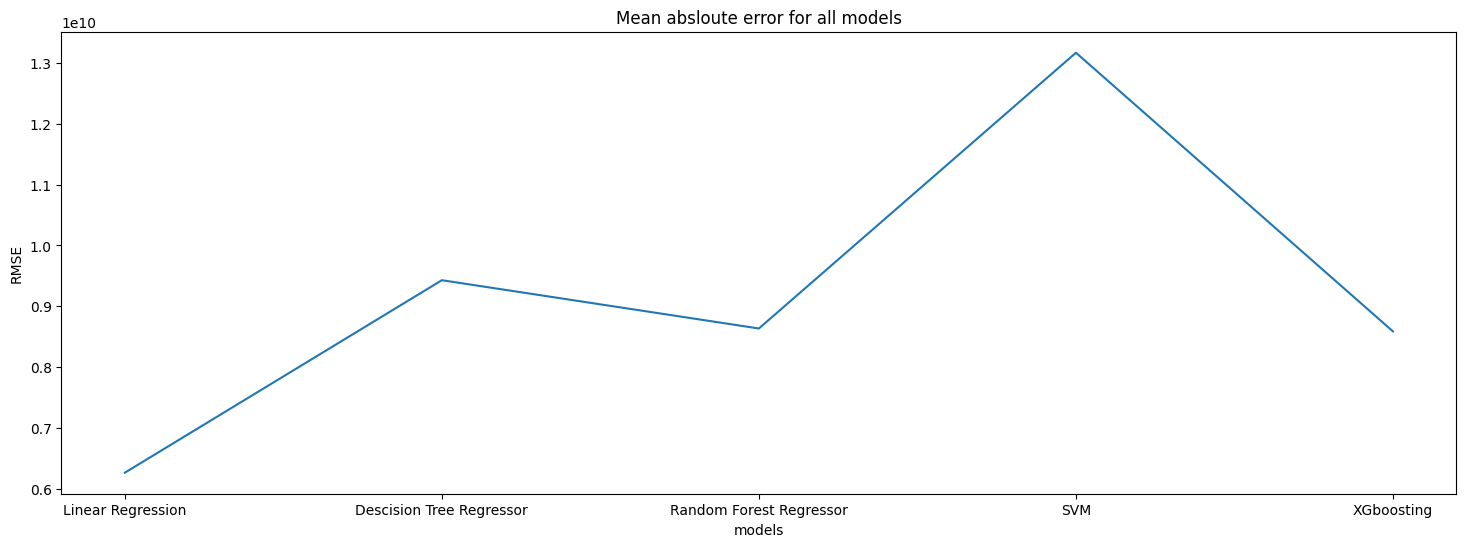

{'Linear Regression': 6270175103.21841,
 'Descision Tree Regressor': 9429452933.79156,
 'Random Forest Regressor': 8636989078.46878,
 'SVM': 13162593064.847214,
 'XGboosting': 8588992177.453096}

In [22]:
comp_rmse = {'Linear Regression':rmse_LinReg,
      'Descision Tree Regressor': rmse_DecTree,
      'Random Forest Regressor': rmse_RF,
      'SVM': rmse_SV,       
      'XGboosting':rmse_xgb}

plt.figure(figsize=(18,6))
sns.lineplot(x=comp_rmse.keys(),y=comp_rmse.values())
plt.title('Mean absloute error for all models')
plt.xlabel('models')
plt.ylabel('RMSE')
plt.show()

comp_rmse

terlihat bahwa algoritma Linear Regression memiliki nilai terendah pada MSE nya. Maka dari itu kita gunakan Linear Regression untuk memprediksi testing datasetnya.

In [23]:
pred_test = LinReg.predict(xtest)

In [24]:
output = pd.DataFrame({'Actual': ytest,
                       'Predict': pred_test})

output

,Actual,Predict
30,38534274544,2.552695e+10
0,254545455,4.271930e+08
22,26337563295,2.602265e+10
31,39291637273,4.503022e+10
18,19823029750,1.135725e+10
28,32613800004,2.604200e+10
10,22508888218,2.067196e+10
53,9904545455,1.391119e+10
4,12921200000,8.761917e+09


In [25]:
def mape(ytest, pred_test):
    ytest, pred = np.array(ytest), np.array(pred_test)
    mape = np.mean(np.abs((ytest - pred_test) / ytest))
    return mape

In [26]:
print(mape(ytest, pred_test))

0.2900467871206292
